In [3]:
suppressMessages({
    require(Seurat)
    library(dplyr)
    library(ggtree)
    library(phangorn)
    library(cluster)
    library(ggplot2)
    library(ape)
    library(hash)
})


PercentAbove <- function(x, threshold) { return(length(x = x[x > threshold]) / length(x = x)) }
get_pct_matrix <- function(object, vars, cells, group.by){
    data.features <- FetchData(object = object, vars = vars, cells = cells)
    data.features$id <- if (!is.null(x = group.by)) {
        object[[group.by, drop = TRUE]][cells, drop = TRUE]
    }
    
    res <- Reduce(rbind, lapply(X = unique(x = data.features$id), FUN = function(ident) {
        data.use <- data.features[data.features$id == ident, 1:(ncol(x = data.features) - 1), drop = FALSE]
        pct.exp <- apply(X = data.use, MARGIN = 2, FUN = PercentAbove, threshold = 0)
        return(pct.exp)
    }))
    rownames(res) <- unique(data.features$id)
    res <- t(res)
    return(res)
}

In [4]:
TF <- read.table('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/09.GRNs_detection/1.mouse/0.bin/allTFs_mm.txt', header =F)$V1

In [3]:
load('../GSM4873765_mouse_data.RData')
# we focus on region variant excitatory neurons rather than invariant inhibitory neurons
RL@meta.data$DCN_class <- factor(paste(RL@meta.data$DCN, RL@meta.data$classes, sep  = '_'), levels = 
                                 c('Lat_ClassA','Int_ClassA','Med_ClassA','Lat_ClassB','Int_ClassB','Med_ClassB'))
Idents(RL) <- "DCN_class"
RL@meta.data$final.clusters <- as.character(RL@meta.data$final.clusters)
RL@meta.data$final.clusters2 <- as.character(RL@meta.data$final.clusters2)
RL <- SCTransform(RL, verbose = F)

In [4]:
RL <- UpdateSeuratObject(RL)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc ‘pca’

Updating matrix keys for DimReduc ‘tsne’

Updating matrix keys for DimReduc ‘umap’

Warning message:
“Assay RNA changing from Assay to Assay”
Warning message:
“Graph RNA_nn changing from Graph to Graph”
Warning message:
“Graph RNA_snn changing from Graph to Graph”
Warning message:
“DimReduc pca changing from DimReduc to DimReduc”
Warning message:
“DimReduc tsne changing from DimReduc to DimReduc”
Warning message:
“DimReduc umap changing from DimReduc to DimReduc”
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in SCT

Updating slots in RNA_nn

Setting default assay of RNA_nn to RNA

Updating slots in RNA_snn

Setting default assay of RNA_snn to RNA

Updating slots in pca

Updating slots in tsne

Setting tsne DimReduc to global

Updating slots in umap

Setting umap 

In [5]:
RL_A <- subset(RL, cells = colnames(RL)[which(RL@meta.data$classes == 'ClassA')])
RL_B <- subset(RL, cells = colnames(RL)[which(RL@meta.data$classes == 'ClassB')])

markers_A <- FindAllMarkers(RL_A, only.pos = T, test.use = "wilcox", assay = "SCT", verbose = F)
markers_B <- FindAllMarkers(RL_B, only.pos = T, test.use = "wilcox", assay = "SCT", verbose = F)

markers <- rbind(markers_A, markers_B)

In [6]:
#markers <- FindAllMarkers(RL, only.pos = T, test.use = "wilcox", assay = "SCT", verbose = F)
#markers <- markers[markers$p_val_adj < 0.01, ]
#write.table(x = markers, file = "cerebellar_nuclei.excitatory.markers.txt", quote = F, sep = "\t", col.names = T, row.names = F)

In [7]:
# markers might be influenced the number/quality of cells in each cluster,
# based on several testing, I used very strigent filtering to get more 'significant' markers for each cell type
markers <- markers %>% filter(p_val_adj < 0.01 & avg_log2FC > 1 & pct.1 > 0.1 & (pct.1/(pct.2+0.01)) > 1.5)

In [8]:
table(markers$cluster)


Lat_ClassA Int_ClassA Med_ClassA Lat_ClassB Int_ClassB Med_ClassB 
        21          6         20         11         12         68 

In [9]:
Mmus_pct <- get_pct_matrix(object = RL, vars = rownames(RL), cells=colnames(RL), group.by="DCN_class")

In [10]:
binary_matrix <- Mmus_pct
binary_matrix[binary_matrix > 0.1] <- 1
binary_matrix[binary_matrix != 1] <- 0

In [11]:
# binarize gene matrix as 1 (marker) or 0 (not marker)
binary_matrix <- Mmus_pct
binary_matrix <- binary_matrix[rownames(binary_matrix) %in% unique(markers$gene), ]
binary_matrix[,] <- 0

for (i in unique(as.character(markers$cluster))){
    binary_matrix[rownames(binary_matrix) %in% markers[markers$cluster == i, "gene"], i] <- 1
}

In [12]:
# class A and B excitatory neurons
#A <- colnames(binary_matrix)[grepl('\\.A', colnames(binary_matrix))]
#B <- colnames(binary_matrix)[grepl('\\.B', colnames(binary_matrix))]
A <- colnames(binary_matrix)[grepl('ClassA', colnames(binary_matrix))]
B <- colnames(binary_matrix)[grepl('ClassB', colnames(binary_matrix))]
A
B

[1] "Med_ClassA" "Lat_ClassA" "Int_ClassA"

[1] "Med_ClassB" "Int_ClassB" "Lat_ClassB"

In [11]:
# predict ancestral states for class A duplication
phyDat.binary <- phyDat(t(binary_matrix), type = "USER", levels = c(0,1))
NJtree <- read.tree('mouse.classA.tree2')
anc.acctran <- ancestral.pars(NJtree, phyDat.binary, "ACCTRAN", return = "prob")
predicted <- matrix(NA, nrow = length(anc.acctran), ncol = nrow(binary_matrix))
tmp <- lapply(anc.acctran, FUN = function(x) { apply(x, 1, FUN = function(y) {
  if (1 %in% y){c(0,1)[which(y == 1)]} else {0.5}})}) 
node_tip <- length(NJtree$tip.label) + NJtree$Nnode
anc.acctran.binary <- matrix(unlist(tmp), nrow = node_tip, byrow = T)
rownames(anc.acctran.binary) <- names(tmp)

In [12]:
tips <- NJtree$tip.label
inodes <- (length(NJtree$tip.label) + 2):(length(NJtree$tip.label) + NJtree$Nnode)

In [13]:
binary_matrix <- binary_matrix[,rownames(anc.acctran.binary)[1:length(NJtree$tip.label)]]
gain_loss <- hash()

for (i in c(inodes, tips)){
#for (i in c('Lat.A1')){
    if (!is.na(as.integer(i))){
        i <- as.integer(i)
    }
    anode <- getMRCA(NJtree, c(i,i)) # ancestral node
    anc <- anc.acctran.binary[anode, ] # binarized ancestral pattern
    # gain or loss pattern
    gain <- anc.acctran.binary[1:length(NJtree$tip.label), (anc.acctran.binary[i, ] - anc.acctran.binary[anode, ]) == 1, drop = FALSE]
    loss <- anc.acctran.binary[1:length(NJtree$tip.label), (anc.acctran.binary[i, ] - anc.acctran.binary[anode, ]) == -1, drop = FALSE]
    
    gains <- c()
    losses <- c()
    if (ncol(gain) >= 1){
        for (x in 1:ncol(gain)){
            pattern <- gain[,x]
            gains <- c(gains, names(apply(binary_matrix, 1, function(x) all(x == pattern)))[apply(binary_matrix, 1, function(x) all(x == pattern))])
        }
    }
    if (ncol(loss) >= 1){
        for (x in 1:ncol(loss)){
            pattern <- loss[,x]
            losses <- c(losses, names(apply(binary_matrix, 1, function(x) all(x == pattern)))[apply(binary_matrix, 1, function(x) all(x == pattern))])
        }
    }
    
    hash_i <- hash()
    hash_i[['gain']] <- if (is.null(gains)) NA else unique(gains)
    hash_i[['loss']] <- if (is.null(losses)) NA else unique(losses)
    i <- as.character(i)
    gain_loss[[i]] <- hash_i
}

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [14]:
gain_loss

<hash> containing 10 key-value pair(s).
  10 : <hash> containing 2 key-value pair(s).
      gain : NA
      loss : NA
  11 : <hash> containing 2 key-value pair(s).
      gain : Ube2u  Gm9970 Zfp773 Nlrp4a
      loss : Vim           Smpx          Bex1          Slc6a1        Gm20715       1700125H20Rik Gm47847       Rab26        
  8 : <hash> containing 2 key-value pair(s).
      gain : NA
      loss : NA
  9 : <hash> containing 2 key-value pair(s).
      gain : B230208B08Rik 1700001J03Rik Gm46339      
      loss : Cyp27a1            Gm13547            Sult2a4            Rubcnl             Gm47882            Gm49144            Mlana              A230108P19Rik      Cyp4a30-ps         Gm11077            ENSMUSG00000109903
  Int_ClassA : <hash> containing 2 key-value pair(s).
      gain : 4930533P14Rik Klf11         Gm13423       Spry1         Gm44186       Gm30108       Mir300        Kif20a        Gm11846       Gm11210       Gm12671       Wnt9b         Itgb8         AC162863.1    Gm26384 

In [15]:
info <- hash()
for (i in c(inodes, tips)){
    tmp <- gain_loss[[i]][['gain']]
    n_gain <- length(tmp[!is.na(tmp)])
    tmp <- gain_loss[[i]][['loss']]
    n_loss <- length(tmp[!is.na(tmp)])
    text <- paste0('node/tip:',i, '\ngain:', n_gain, '\nloss:', n_loss)
    
    if (!is.na(as.integer(i))){
        info[[i]] <- text
    } else {
        i = as.character(names(setNames(tips, 1:length(tips))[setNames(tips, 1:length(tips)) == i]))
        info[[i]] <- text 
    }
}

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [16]:
p = ggtree(NJtree, ladderize=F) + geom_tiplab() + ggtitle("ggtree")
edge=data.frame(NJtree$edge, edge_text= vapply(as.character(NJtree$edge[,2]), FUN = function(x){info[[x]]}, FUN.VALUE = character(1)) )
colnames(edge)=c("parent", "node", "edge_text")
p <- p %<+% edge + geom_label(aes(x=branch, label=edge_text)) + geom_text2(aes(subset = !isTip, label = node))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_label()`).”


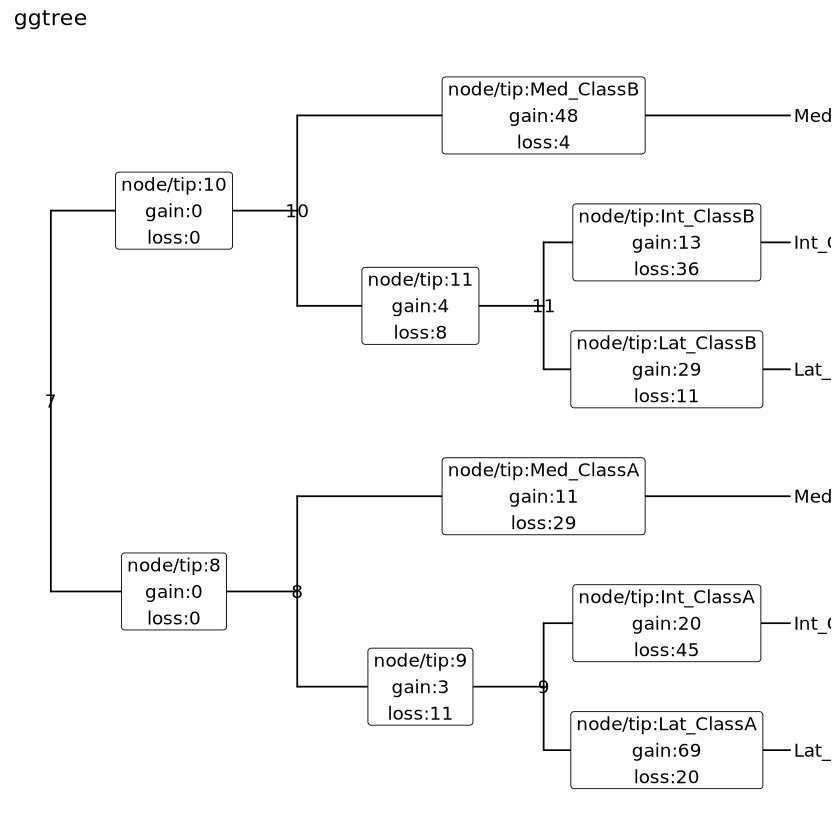

In [17]:
p
ggsave(filename = "mouse.classAB.gene.pdf", p, width = 7, height = 7)

In [18]:
p1 <- DotPlot(RL_A, features = c(
                         gain_loss[['Med_ClassA']][['gain']],
                         gain_loss[['Int_ClassA']][['gain']],
                         gain_loss[['Lat_ClassA']][['gain']]
                        )) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

p2 <- DotPlot(RL_B, features = c(gain_loss[['Med_ClassB']][['gain']],
                         gain_loss[['Int_ClassB']][['gain']],
                         gain_loss[['Lat_ClassB']][['gain']]
                        )) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


In [24]:
ggsave(filename = "Dotplot.genes.mouse.pdf", p, width = 15, height = 7)

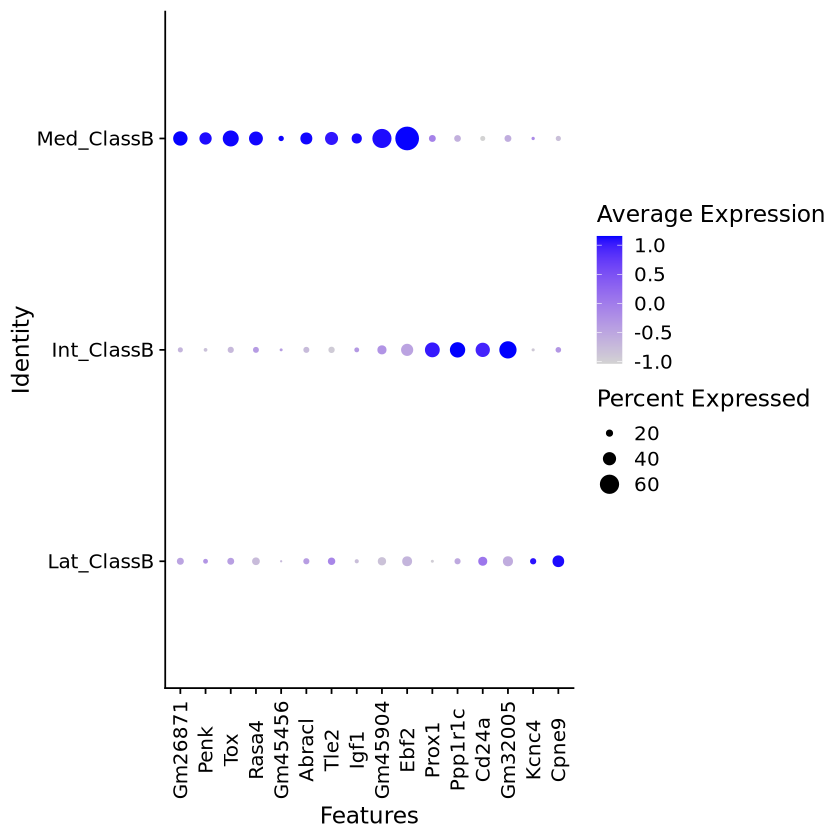

In [27]:
p1
p2

In [33]:
p3 <- DotPlot(RL, features = unique(c(
                         gain_loss[['Med_ClassA']][['gain']],
                         gain_loss[['Med_ClassB']][['gain']]
                        )), cluster.idents = T) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

In [34]:
p3

In [37]:
markers_A[markers_A$gene == 'Pou6f2',]

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster    gene  
Pou6f2 1.304331e-17 1.846639   0.477 0.225 3.762603e-13 Med_ClassA Pou6f2

In [38]:
markers_B[markers_B$gene == 'Pou6f2',]

p_val       avg_log2FC pct.1 pct.2 p_val_adj    cluster    gene  
Pou6f2 1.85974e-17 1.844079   0.451 0.245 5.364791e-13 Med_ClassB Pou6f2